# Times Series Econometrics Project

In [1]:
# Import Librabries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from pandas_datareader import data as web
import datetime

from arch.unitroot import ADF, KPSS
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from statsmodels.tsa.api import VAR

import warnings
warnings.filterwarnings("ignore")

### Data gathering and collection

In [2]:
# Data gathering and collection

start = datetime.datetime(1959, 1, 1)
end = datetime.datetime(2025, 10, 1)

# Download data from FRED
pce = web.DataReader('PCECC96', 'fred', start, end)
dpi = web.DataReader('DPIC96', 'fred', start, end)
gdp = web.DataReader('GDP', 'fred', start, end)  # optional variable for advanced work

# Merge and clean
data = pd.concat([pce, dpi, gdp], axis=1)
data.columns = ['PCE', 'DPI', 'GDP']
data = data.dropna()
data.tail()

,PCE,DPI,GDP
DATE,,,
2024-04-01,16009.637,17700.963,29147.044
2024-07-01,16165.768,17755.291,29511.664
2024-10-01,16320.890,17843.165,29825.182
2025-01-01,16345.793,17943.157,30042.113
2025-04-01,16445.685,18082.022,30485.729


### Pre-Estimation Analysis

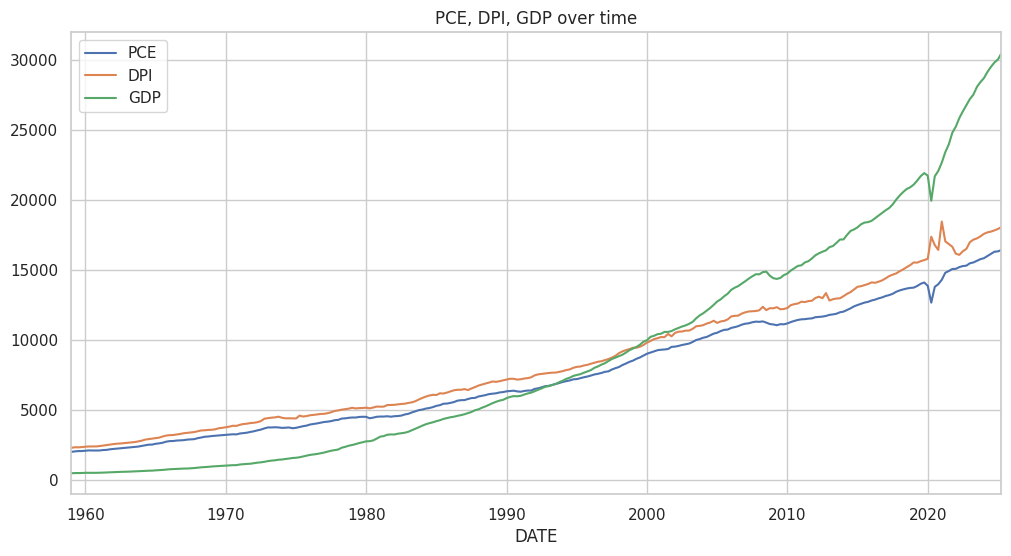

=== Stationarity Tests ===
ADF Test: ln_pce level
   Augmented Dickey-Fuller Results   
Test Statistic                 -1.564
P-value                         0.806
Lags                                0
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.99 (1%), -3.43 (5%), -3.14 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


ADF Test: ln_dpi level
   Augmented Dickey-Fuller Results   
Test Statistic                 -2.302
P-value                         0.433
Lags                                6
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.99 (1%), -3.43 (5%), -3.14 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


ADF Test: ln_gdp level
   Augmented Dickey-Fuller Results   
Test Statistic                 -0.399
P-value                         0.987
Lags

In [3]:
# Pre-Estimation Analysis

# Visual inspection
data.plot(figsize=(12,6), title="PCE, DPI, GDP over time")
plt.show()

# Log transformation for variance stabilization
data['ln_pce'] = np.log(data['PCE'])
data['ln_dpi'] = np.log(data['DPI'])
data['ln_gdp'] = np.log(data['GDP'])

# Stationarity tests
def adf_test(series, title):
    print(f'ADF Test: {title}')
    print(ADF(series, trend='ct').summary())
    print("\n")

def kpss_test(series, title):
    print(f'KPSS Test: {title}')
    print(KPSS(series, trend='ct').summary())
    print("\n")

print("=== Stationarity Tests ===")
adf_test(data['ln_pce'], 'ln_pce level')
adf_test(data['ln_dpi'], 'ln_dpi level')
adf_test(data['ln_gdp'], 'ln_gdp level')
adf_test(data['ln_pce'].diff().dropna(), 'Δln_pce')
adf_test(data['ln_dpi'].diff().dropna(), 'Δln_dpi')
adf_test(data['ln_gdp'].diff().dropna(), 'Δln_gdp')


### Cointegration Analysis (Johansen)

In [4]:
# Cointegration Analysis (Johansen)

johansen_test = coint_johansen(data[['ln_pce', 'ln_dpi']], det_order=1, k_ar_diff=2)
print("=== Johansen Test ===")
print("Trace statistic:", johansen_test.trace_stat)
print("Critical values:", johansen_test.cvt)

=== Johansen Test ===
Trace statistic: [19.4704735   3.65278798]
Critical values: [[16.1619 18.3985 23.1485]
 [ 2.7055  3.8415  6.6349]]


### VECM Estimation

In [5]:
# 4. VECM Estimation

vecm_model = VECM(
    data[['ln_pce', 'ln_dpi']],
    k_ar_diff=4,
    coint_rank=1,
    deterministic="ci"
)
vecm_fit = vecm_model.fit()
print("=== VECM Summary ===")
print(vecm_fit.summary())

=== VECM Summary ===
Det. terms outside the coint. relation & lagged endog. parameters for equation ln_pce
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.ln_pce     -0.0261      0.065     -0.402      0.688      -0.153       0.101
L1.ln_dpi      0.3358      0.050      6.774      0.000       0.239       0.433
L2.ln_pce      0.0471      0.064      0.741      0.459      -0.077       0.172
L2.ln_dpi      0.1633      0.050      3.273      0.001       0.065       0.261
L3.ln_pce      0.0067      0.065      0.104      0.917      -0.120       0.134
L3.ln_dpi      0.1225      0.049      2.517      0.012       0.027       0.218
L4.ln_pce      0.0653      0.067      0.977      0.329      -0.066       0.196
L4.ln_dpi      0.0149      0.048      0.307      0.759      -0.080       0.110
Det. terms outside the coint. relation & lagged endog. parameters for equation ln_dpi
                 

### Post-Estimation Analysis (IRF)

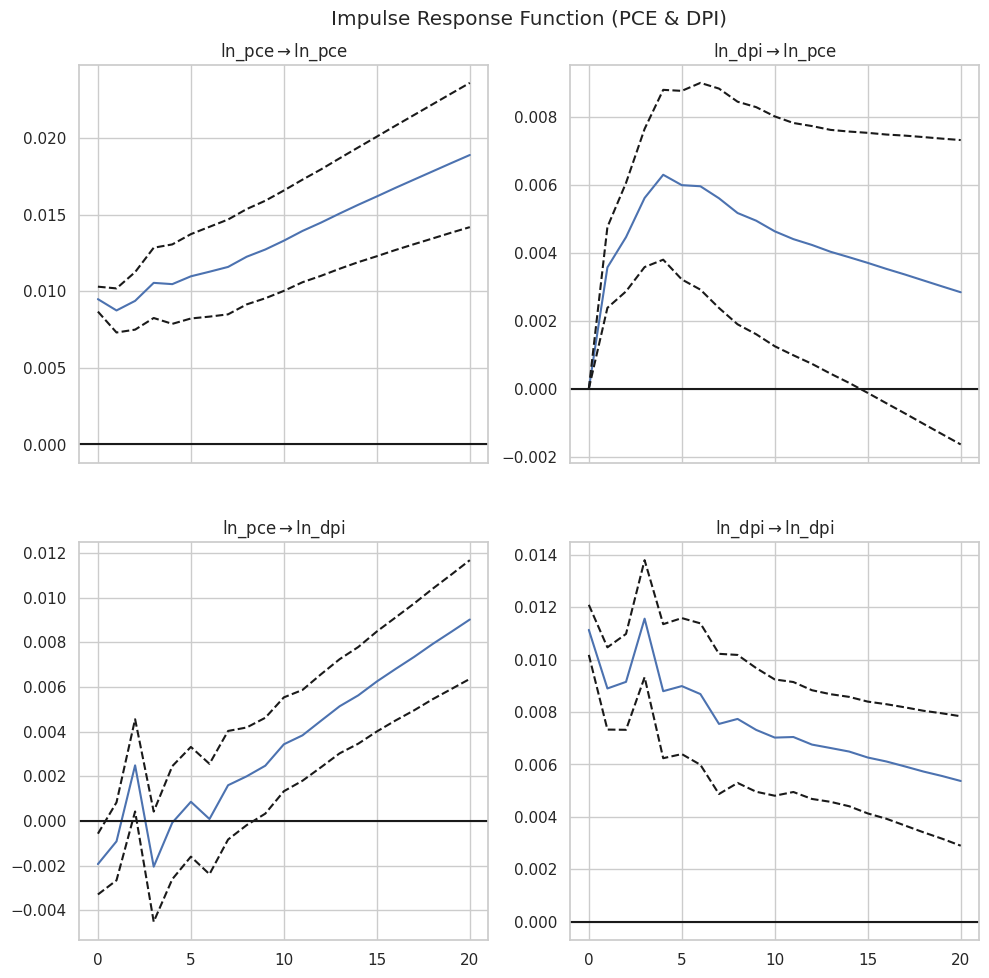

In [6]:
# Post-Estimation Analysis (IRF)

irf = vecm_fit.irf(20)
irf.plot(orth=True, signif=0.05)
plt.suptitle("Impulse Response Function (PCE & DPI)")
plt.show()

### Forecasting with Confidence Intervals

In [7]:
# 6. Forecasting with Confidence Intervals

steps = 12  # forecast horizon
forecast_vals, lower_vals, upper_vals = vecm_fit.predict(steps=steps, alpha=0.05)

forecast_df = pd.DataFrame(np.exp(forecast_vals), columns=['PCE_forecast', 'DPI_forecast'])
lower_df = pd.DataFrame(np.exp(lower_vals), columns=['PCE_lower', 'DPI_lower'])
upper_df = pd.DataFrame(np.exp(upper_vals), columns=['PCE_upper', 'DPI_upper'])

forecast_ci = pd.concat([forecast_df, lower_df, upper_df], axis=1)
print("VECM Forecast with 95% CI: \n")
forecast_ci

VECM Forecast with 95% CI: 



,PCE_forecast,DPI_forecast,PCE_lower,DPI_lower,PCE_upper,DPI_upper
0,16543.509330,18112.374014,16238.812727,17715.737180,16853.923100,18517.891131
1,16619.298163,18252.004211,16188.903973,17743.779790,17061.134706,18774.785399
2,16708.520962,18344.364848,16162.878490,17734.628591,17272.583772,18975.064515
3,16791.501662,18418.482711,16122.917170,17680.559691,17487.810989,19187.203985
4,16873.389677,18531.452256,16096.125862,17727.149409,17688.186687,19372.247325
5,16958.663320,18617.822729,16080.875221,17749.370501,17884.366220,19528.767128
6,17039.671355,18710.325189,16067.704249,17785.179251,18070.434668,19683.595185
7,17122.509174,18809.794830,16062.234787,17840.367128,18252.772686,19831.900264
8,17205.502602,18899.216071,16057.813410,17884.586199,18435.219804,19971.408011
9,17287.070353,18994.797173,16053.403249,17938.453279,18615.541936,20113.346118


### Plot forecast

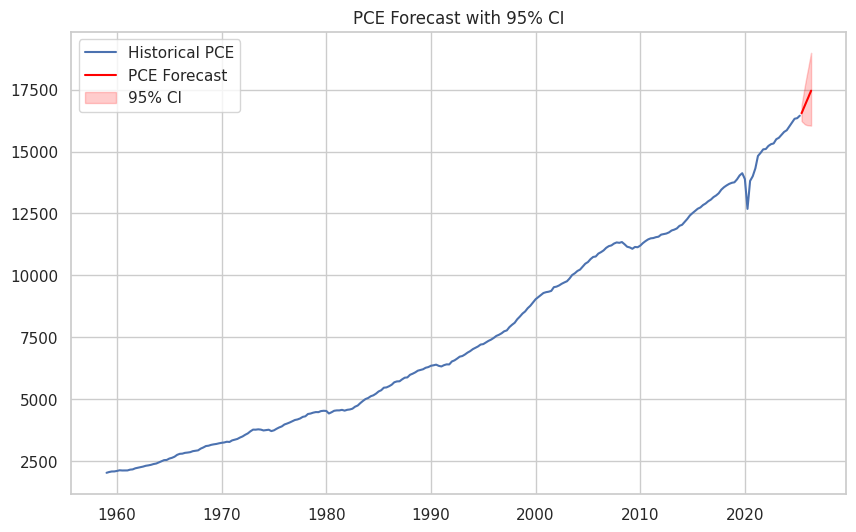

In [8]:
# Plot forecast
last_date = data.index[-1]
future_index = pd.date_range(start=last_date, periods=steps+1, freq="M")[1:]

plt.figure(figsize=(10,6))
plt.plot(data.index, data['PCE'], label='Historical PCE')
plt.plot(future_index, forecast_df['PCE_forecast'], color='red', label='PCE Forecast')
plt.fill_between(future_index, lower_df['PCE_lower'], upper_df['PCE_upper'], color='red', alpha=0.2, label='95% CI')
plt.title('PCE Forecast with 95% CI')
plt.legend()
plt.show()

### Compare VECM to VAR

In [9]:
# Compare VECM to VAR
var_model = VAR(data[['ln_pce', 'ln_dpi']])
var_fit = var_model.fit(maxlags=4)
var_forecast = var_fit.forecast(y=data[['ln_pce', 'ln_dpi']].values[-var_fit.k_ar:], steps=12)
var_forecast_df = pd.DataFrame(np.exp(var_forecast), columns=['PCE_forecast_VAR', 'DPI_forecast_VAR'])
print("VAR Forecast (Next 12 Periods): \n")
var_forecast_df

VAR Forecast (Next 12 Periods): 



,PCE_forecast_VAR,DPI_forecast_VAR
0,16548.662420,18108.083644
1,16630.219789,18246.313860
2,16732.309389,18334.339971
3,16824.305692,18405.481622
4,16914.942806,18517.257608
5,17010.024206,18599.808467
6,17100.371113,18690.859354
7,17192.581364,18790.163547
8,17285.406027,18879.888526
9,17377.210400,18976.696839


### Include GDP as additional variable in VECM

In [10]:
# Include GDP as additional variable in VECM
vecm_model_gdp = VECM(
    data[['ln_pce', 'ln_dpi', 'ln_gdp']],
    k_ar_diff=4,
    coint_rank=1,
    deterministic="ci"
)
vecm_fit_gdp = vecm_model_gdp.fit()
print("=== VECM with GDP Summary ===")
print(vecm_fit_gdp.summary())

=== VECM with GDP Summary ===
Det. terms outside the coint. relation & lagged endog. parameters for equation ln_pce
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.ln_pce     -0.0609      0.094     -0.649      0.516      -0.245       0.123
L1.ln_dpi      0.2871      0.053      5.392      0.000       0.183       0.391
L1.ln_gdp      0.0173      0.083      0.209      0.835      -0.145       0.180
L2.ln_pce     -0.0177      0.091     -0.193      0.847      -0.197       0.161
L2.ln_dpi      0.1140      0.052      2.202      0.028       0.013       0.215
L2.ln_gdp      0.0445      0.081      0.550      0.582      -0.114       0.203
L3.ln_pce      0.1235      0.089      1.391      0.164      -0.050       0.297
L3.ln_dpi      0.0614      0.050      1.232      0.218      -0.036       0.159
L3.ln_gdp     -0.1757      0.081     -2.158      0.031      -0.335      -0.016
L4.ln_pce      

### IRF with GDP

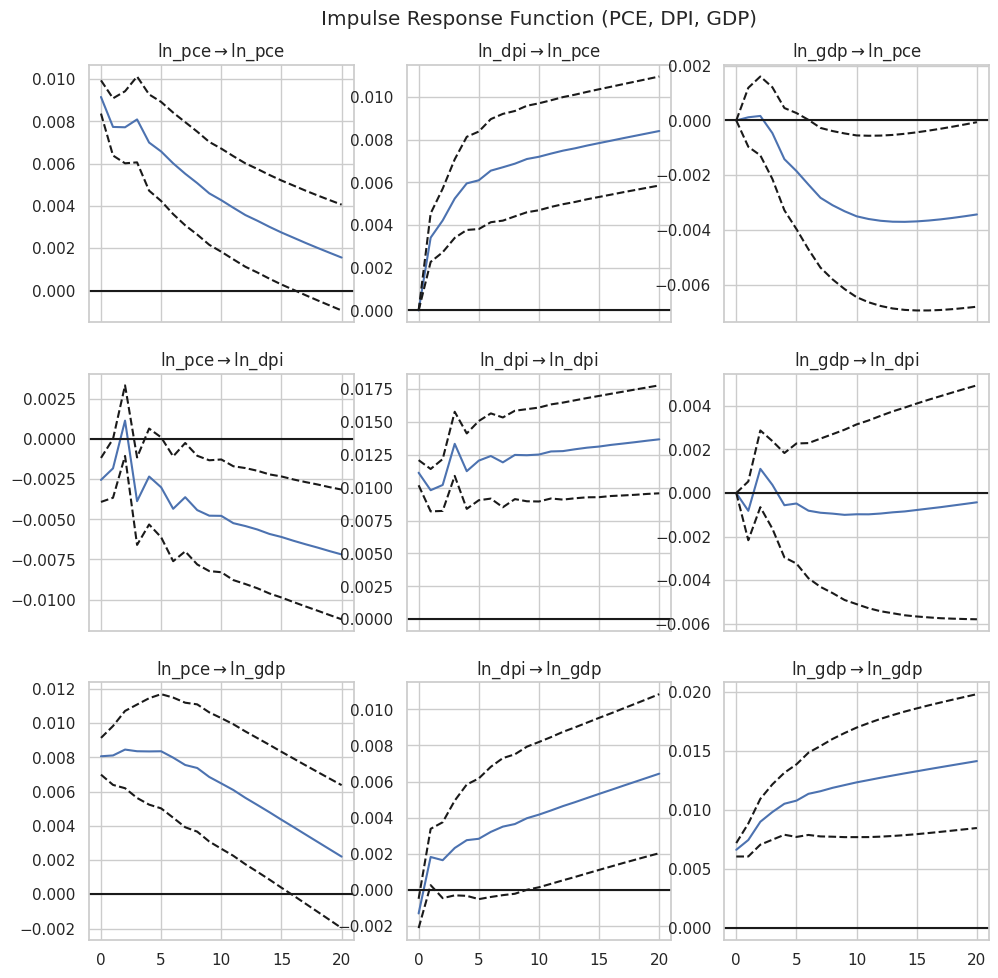

In [11]:
# IRF with GDP
irf_gdp = vecm_fit_gdp.irf(20)
irf_gdp.plot(orth=True, signif=0.05)
plt.suptitle("Impulse Response Function (PCE, DPI, GDP)")
plt.show()

### Forecast with GDP

In [12]:
# Forecast with GDP
forecast_gdp_vals, lower_gdp_vals, upper_gdp_vals = vecm_fit_gdp.predict(steps=12, alpha=0.05)
forecast_gdp_df = pd.DataFrame(np.exp(forecast_gdp_vals), columns=['PCE_forecast', 'DPI_forecast', 'GDP_forecast'])
print("VECM Forecast with GDP (Next 12 Periods): \n")
forecast_gdp_df

VECM Forecast with GDP (Next 12 Periods): 



,PCE_forecast,DPI_forecast,GDP_forecast
0,16564.106694,18117.732846,30851.581843
1,16657.127985,18289.149455,31211.855568
2,16751.435271,18374.981808,31566.031606
3,16835.808606,18443.685209,31910.858139
4,16923.823736,18556.024800,32253.629708
5,17010.903171,18637.144105,32611.197661
6,17096.139823,18730.557103,32956.103865
7,17184.857530,18829.080822,33309.847955
8,17272.784003,18919.387898,33665.370745
9,17360.869605,19015.968361,34021.558607
